## Tutorial 3 - Turboprop Aircraft Simulation
Welcome to this tutorial on simulating a turboprop aircraft using RCAIDE. This guide will walk you through the code, explain its components, and highlight where modifications can be made to customize the simulation for different vehicle designs.

---

## Header and Imports


The **Imports** section is divided into two parts: simulation-specific libraries and general-purpose Python libraries.

The **RCAIDE Imports** section includes the core modules needed for the simulation. These libraries provide specialized classes and tools for building, analyzing, and running aircraft models.


In [12]:
# RCAIDE imports 
import RCAIDE
from RCAIDE.Framework.Core                                         import Units  
from RCAIDE.Library.Methods.Powertrain.Propulsors.Turboprop         import design_turboprop
from RCAIDE.Library.Plots                                          import *      

# python imports     
import numpy as np  
import sys
import matplotlib.pyplot as plt  
from copy import deepcopy
import pickle
import os 
sys.path.insert(0,(os.path.dirname(os.getcwd())))

## Vehicle Setup

The **`vehicle_setup`** function defines the baseline configuration of the aircraft. This section builds the vehicle step-by-step by specifying its components, geometric properties, and high-level parameters.

---

### 1. Creating the Vehicle Instance

The setup begins by creating a vehicle instance and assigning it a **tag**. The tag is a unique string identifier used to reference the vehicle during analysis or in post-processing steps.

---

### 2. Defining High-Level Vehicle Parameters

The high-level parameters describe the aircraft’s key operational characteristics, such as:

- **Maximum Takeoff Weight**: The heaviest allowable weight of the aircraft for safe flight.
- **Operating Empty Weight**: The aircraft weight without fuel, passengers, or payload.
- **Payload**: The weight of cargo and passengers.
- **Max Zero Fuel Weight**: The maximum weight of the aircraft excluding fuel.

Units for these parameters can be converted automatically using the `Units` module to ensure consistency and reduce errors.

---

### 3. Defining the Landing Gear

Landing gear parameters, such as the number of main and nose wheels, are set for the aircraft. While not used in this tutorial, these values can be applied in advanced analyses, such as **ground loads** or **noise prediction**.

---

### 4. Main Wing Setup

The main wing is added using the **`Main_Wing`** class. This designation ensures that the primary lifting surface is recognized correctly by the analysis tools. Key properties of the wing include:

- **Area**: The total wing surface area.
- **Span**: The length of the wing from tip to tip.
- **Aspect Ratio**: A ratio of span to average chord, determining wing efficiency.
- **Segments**: Divisions of the wing geometry (e.g., root and tip sections).
- **Control Surfaces**: High-lift devices like flaps and ailerons, defined by span fractions and deflections.

---

### 5. Horizontal and Vertical Stabilizers

The stabilizers provide stability and control for the aircraft:

- **Horizontal Stabilizer**: Defined using the `Horizontal_Tail` class. It follows a similar setup to the main wing but acts as a stabilizing surface.
- **Vertical Stabilizer**: Defined using the `Vertical_Tail` class, with an additional option to designate the tail as a **T-tail** for weight calculations.

---

### 6. Fuselage Definition

The fuselage is modeled by specifying its geometric parameters, such as:

- **Length**: The overall length of the aircraft body.
- **Width**: The widest part of the fuselage cross-section.
- **Height**: The height of the fuselage.

These values influence drag calculations and overall structural weight.

---

### 7. Energy Network: Turboprop Engine

The **energy network** models the propulsion system, in this case, a turboprop engine. The turboprop network determines the engine’s thrust, bypass ratio, and fuel type. These parameters are essential for performance and fuel efficiency analyses.

More detailed information about turboprop behavior and configurations is provided in the **turboprop Modeling Tutorial**.

---

In [13]:
def vehicle_setup(): 
# ------------------------------------------------------------------
    #   Initialize the Vehicle
    # ------------------------------------------------------------------

    vehicle = RCAIDE.Vehicle()
    vehicle.tag = 'ATR_72'

    # ------------------------------------------------------------------
    #   Vehicle-level Properties
    # ------------------------------------------------------------------

    # mass properties
    vehicle.mass_properties.max_takeoff               = 23000 
    vehicle.mass_properties.takeoff                   = 23000  
    vehicle.mass_properties.operating_empty           = 13600  
    vehicle.mass_properties.max_zero_fuel             = 21000 
    vehicle.mass_properties.cargo                     = 7400
    vehicle.mass_properties.center_of_gravity         = [[0,0,0]] # Unknown 
    vehicle.mass_properties.moments_of_inertia.tensor = [[0,0,0]] # Unknown 
    vehicle.mass_properties.max_fuel                  = 5000
    vehicle.design_mach_number                        = 0.41 
    vehicle.design_range                              = 5471000 *Units.meter  
    vehicle.design_cruise_alt                         = 25000 *Units.feet

    # envelope properties
    vehicle.flight_envelope.design_mach_number        = 0.43 
    vehicle.flight_envelope.design_range              = 890 * Units.nmi
    vehicle.flight_envelope.design_cruise_altitude    = 25000 * Units.feet
    vehicle.flight_envelope.ultimate_load             = 3.75
    vehicle.flight_envelope.positive_limit_load       = 1.5
    
    # basic parameters              
    vehicle.reference_area                            = 61.0  
    vehicle.passengers                                = 72
    vehicle.systems.control                           = "fully powered"
    vehicle.systems.accessories                       = "short range"  

 
    # ------------------------------------------------------------------
    #   Main Wing
    # ------------------------------------------------------------------

    wing                                  = RCAIDE.Library.Components.Wings.Main_Wing()
    wing.tag                              = 'main_wing'
    wing.areas.reference                  = 61.0  
    wing.spans.projected                  = 27.05 
    wing.aspect_ratio                     = (wing.spans.projected**2) /  wing.areas.reference
    wing.sweeps.quarter_chord             = 0.0 
    wing.thickness_to_chord               = 0.1 
    wing.chords.root                      = 2.7 
    wing.chords.tip                       = 1.35 
    wing.total_length                     = wing.chords.root  
    wing.taper                            = wing.chords.tip/wing.chords.root 
    wing.chords.mean_aerodynamic          = wing.chords.root * 2/3 * (( 1 + wing.taper + wing.taper**2 )/( 1 + wing.taper )) 
    wing.areas.exposed                    = 2 * wing.areas.reference
    wing.areas.wetted                     = 2 * wing.areas.reference 
    wing.twists.root                      = 4 * Units.degrees  
    wing.twists.tip                       = 0 * Units.degrees   
    wing.origin                           = [[11.52756129,0,2.009316366]]  
    wing.aerodynamic_center               = [11.52756129 + 0.25*wing.chords.root ,0,2.009316366]  
    wing.vertical                         = False   
    wing.symmetric                        = True  
    wing.dynamic_pressure_ratio           = 1.0 
 

    # Wing Segments 
    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'inboard'
    segment.percent_span_location         = 0.0
    segment.twist                         = 4.0 * Units.deg
    segment.root_chord_percent            = 1. 
    segment.dihedral_outboard             = 0.0  * Units.degrees
    segment.sweeps.quarter_chord          = 0.0 * Units.degrees
    segment.thickness_to_chord            = .1 
    wing.append_segment(segment)
 
    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'outboard'
    segment.percent_span_location         = 0.324
    segment.twist                         = 3.0 * Units.deg
    segment.root_chord_percent            = 1.0
    segment.dihedral_outboard             = 0.0 * Units.degrees
    segment.sweeps.leading_edge           = 4.7 * Units.degrees
    segment.thickness_to_chord            = .1 
    wing.append_segment(segment) 
 
    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'tip'
    segment.percent_span_location         = 1.
    segment.twist                         = 0. * Units.degrees
    segment.root_chord_percent            = wing.taper 
    segment.thickness_to_chord            = 0.1
    segment.dihedral_outboard             = 0.
    segment.sweeps.quarter_chord          = 0.  
    wing.append_segment(segment)     
  
    # add to vehicle
    vehicle.append_component(wing)


    # ------------------------------------------------------------------
    #  Horizontal Stabilizer
    # ------------------------------------------------------------------ 
    wing                         = RCAIDE.Library.Components.Wings.Horizontal_Tail()
    wing.tag                     = 'horizontal_stabilizer'  
    wing.spans.projected         = 3.61*2 
    wing.areas.reference         = 15.2 
    wing.aspect_ratio            = (wing.spans.projected**2) /  wing.areas.reference
    wing.sweeps.leading_edge     = 11.56*Units.degrees  
    wing.thickness_to_chord      = 0.1  
    wing.chords.root             = 2.078645129 
    wing.chords.tip              = 0.953457347 
    wing.total_length            = wing.chords.root  
    wing.taper                   = wing.chords.tip/wing.chords.root  
    wing.chords.mean_aerodynamic = wing.chords.root * 2/3 * (( 1 + wing.taper + wing.taper**2 )/( 1 + wing.taper )) 
    wing.areas.exposed           = 2 * wing.areas.reference
    wing.areas.wetted            = 2 * wing.areas.reference 
    wing.twists.root             = 0 * Units.degrees  
    wing.twists.tip              = 0 * Units.degrees   
    wing.origin                  = [[25.505088,0,5.510942426]]  
    wing.aerodynamic_center      = [25.505088+ 0.25*wing.chords.root,0,2.009316366] 
    wing.vertical                = False  
    wing.symmetric               = True  
    wing.dynamic_pressure_ratio  = 1.0 

    # add to vehicle
    vehicle.append_component(wing)


    # ------------------------------------------------------------------
    #   Vertical Stabilizer
    # ------------------------------------------------------------------ 
    wing                                   = RCAIDE.Library.Components.Wings.Vertical_Tail()
    wing.tag                               = 'vertical_stabilizer'   
    wing.spans.projected                   = 4.5  
    wing.areas.reference                   = 12.7
    wing.sweeps.quarter_chord              = 54 * Units.degrees  
    wing.thickness_to_chord                = 0.1  
    wing.aspect_ratio                      = (wing.spans.projected**2) /  wing.areas.reference    
    wing.chords.root                       = 8.75
    wing.chords.tip                        = 1.738510759 
    wing.total_length                      = wing.chords.root  
    wing.taper                             = wing.chords.tip/wing.chords.root  
    wing.chords.mean_aerodynamic           = wing.chords.root * 2/3 * (( 1 + wing.taper + wing.taper**2 )/( 1 + wing.taper )) 
    wing.areas.exposed                     = 2 * wing.areas.reference
    wing.areas.wetted                      = 2 * wing.areas.reference 
    wing.twists.root                       = 0 * Units.degrees  
    wing.twists.tip                        = 0 * Units.degrees   
    wing.origin                            = [[17.34807199,0,1.3]]  
    wing.aerodynamic_center                = [17.34807199,0,1.3+ 0.25*wing.chords.root]   
    wing.vertical                          = True  
    wing.symmetric                         = False  
    wing.t_tail                            = True  
    wing.dynamic_pressure_ratio            = 1.0  
 

    # Wing Segments
    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'segment_1'
    segment.percent_span_location         = 0.0
    segment.twist                         = 0.0
    segment.root_chord_percent            = 1.0
    segment.dihedral_outboard             = 0.0
    segment.sweeps.leading_edge           = 75 * Units.degrees  
    segment.thickness_to_chord            = 1.0
    wing.append_segment(segment)

    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'segment_2'
    segment.percent_span_location         = 1.331360381/wing.spans.projected
    segment.twist                         = 0.0
    segment.root_chord_percent            = 4.25/wing.chords.root  
    segment.dihedral_outboard             = 0   
    segment.sweeps.leading_edge           = 54 * Units.degrees   
    segment.thickness_to_chord            = 0.1
    wing.append_segment(segment)

    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'segment_3'
    segment.percent_span_location         = 3.058629978/wing.spans.projected
    segment.twist                         = 0.0
    segment.root_chord_percent            = 2.35/wing.chords.root    
    segment.dihedral_outboard             = 0 
    segment.sweeps.leading_edge           = 31 * Units.degrees   
    segment.thickness_to_chord            = 0.1
    wing.append_segment(segment)
    

    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'segment_4'
    segment.percent_span_location         = 4.380739035/wing.spans.projected
    segment.twist                         = 0.0
    segment.root_chord_percent            = 2.190082795/wing.chords.root  
    segment.dihedral_outboard             = 0
    segment.sweeps.leading_edge           = 52 * Units.degrees   
    segment.thickness_to_chord            = 0.1
    wing.append_segment(segment)    
    

    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'segment_5'
    segment.percent_span_location         = 1.0
    segment.twist                         = 0.0
    segment.root_chord_percent            = 1.3/wing.chords.root  
    segment.dihedral_outboard             = 0  
    segment.sweeps.leading_edge           = 0 * Units.degrees   
    segment.thickness_to_chord            = 0.1
    wing.append_segment(segment)    


    # add to vehicle
    vehicle.append_component(wing)


    # ------------------------------------------------------------------
    #  Fuselage
    # ------------------------------------------------------------------ 
    fuselage = RCAIDE.Library.Components.Fuselages.Fuselage()
    fuselage.tag = 'fuselage' 
    fuselage.seats_abreast                      = 4 
    fuselage.seat_pitch                         = 18  
    fuselage.fineness.nose                      = 1.6
    fuselage.fineness.tail                      = 2. 
    fuselage.lengths.total                      = 27.12   
    fuselage.lengths.nose                       = 3.375147531 
    fuselage.lengths.tail                       = 9.2 
    fuselage.effective_diameter                 = 2.985093814  
    fuselage.lengths.cabin                      = fuselage.lengths.total- (fuselage.lengths.nose + fuselage.lengths.tail  )
    fuselage.width                              = 2.985093814  
    fuselage.heights.maximum                    = 2.755708426  
    fuselage.areas.side_projected               = fuselage.heights.maximum * fuselage.lengths.total * Units['meters**2'] 
    fuselage.areas.wetted                       = np.pi * fuselage.width/2 * fuselage.lengths.total * Units['meters**2'] 
    fuselage.areas.front_projected              = np.pi * fuselage.width/2      * Units['meters**2']  
    fuselage.differential_pressure              = 5.0e4 * Units.pascal
    fuselage.heights.at_quarter_length          = fuselage.heights.maximum * Units.meter
    fuselage.heights.at_three_quarters_length   = fuselage.heights.maximum * Units.meter
    fuselage.heights.at_wing_root_quarter_chord = fuselage.heights.maximum* Units.meter
    
     # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_1'    
    segment.percent_x_location                  = 0.0000
    segment.percent_z_location                  = 0.0000
    segment.height                              = 1E-3
    segment.width                               = 1E-3  
    fuselage.segments.append(segment)   
    
    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_2'    
    segment.percent_x_location                  = 0.08732056/fuselage.lengths.total  
    segment.percent_z_location                  = 0.0000
    segment.height                              = 0.459245202 
    segment.width                               = 0.401839552 
    fuselage.segments.append(segment)   
  
    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_3'    
    segment.percent_x_location                  = 0.197094977/fuselage.lengths.total  
    segment.percent_z_location                  = 0.001
    segment.height                              = 0.688749197
    segment.width                               = 0.918490404  
    fuselage.segments.append(segment)   

    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_4'    
    segment.percent_x_location                  = 0.41997031/fuselage.lengths.total 
    segment.percent_z_location                  = 0.0000 
    segment.height                              = 0.975896055   
    segment.width                               = 1.320329956 
    fuselage.segments.append(segment)   

    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_5'    
    segment.percent_x_location                  = 0.753451685/fuselage.lengths.total
    segment.percent_z_location                  = 0.0014551442477876075 # this is given as a percentage of the fuselage length i.e. location of the center of the cross section/fuselage length
    segment.height                              = 1.320329956 
    segment.width                               = 1.664763858 
    fuselage.segments.append(segment)   

    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_6'    
    segment.percent_x_location                  = 1.14389933/fuselage.lengths.total
    segment.percent_z_location                  = 0.0036330994100294946
    segment.height                              = 1.607358208   
    segment.width                               = 2.009316366 
    fuselage.segments.append(segment)   

    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_7'    
    segment.percent_x_location                  = 1.585491874/fuselage.lengths.total
    segment.percent_z_location                  = 0.008262262758112099
    segment.height                              = 2.18141471 
    segment.width                               = 2.411155918 
    fuselage.segments.append(segment)   

    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_8'    
    segment.percent_x_location                  = 2.031242539/fuselage.lengths.total
    segment.percent_z_location                  = 0.013612882669616513
    segment.height                              = 2.468442962  
    segment.width                               = 2.698065563  
    fuselage.segments.append(segment)   

    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_9'    
    segment.percent_x_location                  = 2.59009412/fuselage.lengths.total
    segment.percent_z_location                  = 0.01636321766224188
    segment.height                              = 2.640659912   
    segment.width                               = 2.812876863 
    fuselage.segments.append(segment)   

    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_10'    
    segment.percent_x_location                  = 3.375147531/fuselage.lengths.total
    segment.percent_z_location                  = 0.01860240047935103
    segment.height                              = 2.755708426
    segment.width                               = 2.985093814 
    fuselage.segments.append(segment)   

    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_11'    
    segment.percent_x_location                  = 17.01420312/fuselage.lengths.total 
    segment.percent_z_location                  = 0.01860240047935103
    segment.height                              = 2.755708426
    segment.width                               = 2.985093814 
    fuselage.segments.append(segment)   
 

    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_12'    
    segment.percent_x_location                  = 18.64210783/fuselage.lengths.total
    segment.percent_z_location                  = 0.01860240047935103
    segment.height                              = 2.698302776 
    segment.width                               = 2.927925377  
    fuselage.segments.append(segment)    
     
     
    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_13'    
    segment.percent_x_location                  = 22.7416002/fuselage.lengths.total 
    segment.percent_z_location                  = 0.043363795685840714
    segment.height                              = 1.779575158  
    segment.width                               = 1.722050901 
    fuselage.segments.append(segment)     
    
    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_14'    
    segment.percent_x_location                  = 1.
    segment.percent_z_location                  = 0.06630560070058995
    segment.height                              = 0.401839552 
    segment.width                               = 0.401839552  
    fuselage.segments.append(segment) 
    
    # add to vehicle
    vehicle.append_component(fuselage)  
    
    # ------------------------------------------------------------------
    #   Landing gear
    # ------------------------------------------------------------------  
    landing_gear                                = RCAIDE.Library.Components.Landing_Gear.Landing_Gear()
    main_gear                                   = RCAIDE.Library.Components.Landing_Gear.Main_Landing_Gear()
    nose_gear                                   = RCAIDE.Library.Components.Landing_Gear.Nose_Landing_Gear()
    main_gear.strut_length                      = 12. * Units.inches  
    nose_gear.strut_length                      = 6. * Units.inches 
                                                
    landing_gear.main                           = main_gear
    landing_gear.nose                           = nose_gear
    
    
                                                
    #add to vehicle                             
    vehicle.landing_gear                        = landing_gear

    # ########################################################  Energy Network  #########################################################  
    net                                         = RCAIDE.Framework.Networks.Fuel()    

    #------------------------------------------------------------------------------------------------------------------------- 
    # Fuel Distrubition Line 
    #------------------------------------------------------------------------------------------------------------------------- 
    fuel_line                                       = RCAIDE.Library.Components.Powertrain.Distributors.Fuel_Line()  
 
    #------------------------------------------------------------------------------------------------------------------------------------  
    # Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------    
    starboard_propulsor                              = RCAIDE.Library.Components.Powertrain.Propulsors.Turboprop()    
    starboard_propulsor.tag                          = 'starboard_propulsor' 
    starboard_propulsor.active_fuel_tanks            = ['fuel_tank']   
    starboard_propulsor.origin                       = [[ 9.559106394 ,4.219315295, 1.616135105]]
    starboard_propulsor.design_altitude              = 25000*Units.ft                                   # [-]         Design Altitude
    starboard_propulsor.design_mach_number           = 0.5                                              # [-]         Design Mach number
    starboard_propulsor.design_propeller_efficiency  = 0.86
    starboard_propulsor.design_thrust                = 50000.0 * Units.N                                # [-]         Design Thrust          
    starboard_propulsor.working_fluid                = RCAIDE.Library.Attributes.Gases.Air()            
    starboard_propulsor.design_propeller_efficiency  = 0.83                                             # [-]         Design Propeller Efficiency
    starboard_propulsor.design_gearbox_efficiency    = 0.99                                             # [-]         Design Gearbox Efficiency
    
    # Ram inlet 
    ram                                              = RCAIDE.Library.Components.Powertrain.Converters.Ram()
    ram.tag                                          = 'ram' 
    starboard_propulsor.ram                          = ram 
          
    # inlet nozzle          
    inlet_nozzle                                     = RCAIDE.Library.Components.Powertrain.Converters.Compression_Nozzle()
    inlet_nozzle.tag                                 = 'inlet nozzle'                                       
    inlet_nozzle.pressure_ratio                      = 0.98
    inlet_nozzle.compressibility_effects             = False
    starboard_propulsor.inlet_nozzle                 = inlet_nozzle
                                                     
    # compressor                        
    compressor                                       = RCAIDE.Library.Components.Powertrain.Converters.Compressor()    
    compressor.tag                                   = 'lpc'                   
    compressor.pressure_ratio                        = 10                   
    starboard_propulsor.compressor                   = compressor
    
    # combustor      
    combustor                                        = RCAIDE.Library.Components.Powertrain.Converters.Combustor()   
    combustor.tag                                    = 'Comb'
    combustor.efficiency                             = 0.99                   
    combustor.turbine_inlet_temperature              = 1370                    
    combustor.pressure_ratio                         = 0.96                    
    combustor.fuel_data                              = RCAIDE.Library.Attributes.Propellants.Jet_A()  
    starboard_propulsor.combustor                    = combustor
        
    # high pressure turbine         
    high_pressure_turbine                            = RCAIDE.Library.Components.Powertrain.Converters.Turbine()   
    high_pressure_turbine.tag                        ='hpt'
    high_pressure_turbine.mechanical_efficiency      = 0.99                       
    starboard_propulsor.high_pressure_turbine        = high_pressure_turbine 
        
    # low pressure turbine      
    low_pressure_turbine                             = RCAIDE.Library.Components.Powertrain.Converters.Turbine()   
    low_pressure_turbine.tag                         ='lpt'
    low_pressure_turbine.mechanical_efficiency       = 0.99                      
    starboard_propulsor.low_pressure_turbine         = low_pressure_turbine
    
    # core nozzle    
    core_nozzle                                      = RCAIDE.Library.Components.Powertrain.Converters.Expansion_Nozzle()   
    core_nozzle.tag                                  = 'core nozzle'          
    core_nozzle.pressure_ratio                       = 0.99
    starboard_propulsor.core_nozzle                  = core_nozzle
    
    # design starboard_propulsor
    design_turboprop(starboard_propulsor)
    
    #------------------------------------------------------------------------------------------------------------------------------------ 
    #   Nacelles
    #------------------------------------------------------------------------------------------------------------------------------------ 
    nacelle                                     = RCAIDE.Library.Components.Nacelles.Stack_Nacelle()
    nacelle.tag                                 = 'nacelle_1'
    nacelle.length                              = 5
    nacelle.diameter                            = 0.85 
    nacelle.areas.wetted                        = 1.0   
    nacelle.origin                              = [[8.941625295,4.219315295, 1.616135105 ]]
    nacelle.flow_through                        = False     

    nac_segment                                 = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                             = 'segment_1'
    nac_segment.percent_x_location              = 0.0 
    nac_segment.height                          = 0.0
    nac_segment.width                           = 0.0
    nacelle.append_segment(nac_segment)   

    nac_segment                                 = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                             = 'segment_2'
    nac_segment.percent_x_location              = 0.2 /  nacelle.length
    nac_segment.percent_z_location              = 0 
    nac_segment.height                          = 0.4 
    nac_segment.width                           = 0.4 
    nacelle.append_segment(nac_segment)   

    nac_segment                                 = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                             = 'segment_3'
    nac_segment.percent_x_location              = 0.6 /  nacelle.length
    nac_segment.percent_z_location              = 0 
    nac_segment.height                          = 0.52 
    nac_segment.width                           = 0.700 
    nacelle.append_segment(nac_segment)  

    nac_segment                                 = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                             = 'segment_4'
    nac_segment.percent_x_location              = 0.754 /  nacelle.length
    nac_segment.percent_z_location              = -0.16393 /  nacelle.length
    nac_segment.height                          = 0.9	 
    nac_segment.width                           = 0.85 
    nacelle.append_segment(nac_segment)  

    nac_segment                                 = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                             = 'segment_5'
    nac_segment.percent_x_location              = 1.154  /  nacelle.length
    nac_segment.percent_z_location              = -0.0819  /  nacelle.length
    nac_segment.height                          = 0.8 
    nac_segment.width                           = 0.85 
    nacelle.append_segment(nac_segment)   

    nac_segment                                 = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                             = 'segment_6'
    nac_segment.percent_x_location              = 3.414   / nacelle.length
    nac_segment.percent_z_location              = 0.08197  /  nacelle.length 
    nac_segment.height                          = 0.6 
    nac_segment.width                           = 0.85 
    nacelle.append_segment(nac_segment)


    nac_segment                                 = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                             = 'segment_6'
    nac_segment.percent_x_location              = 0.96 
    nac_segment.percent_z_location              = 0.08197  /  nacelle.length 
    nac_segment.height                          = 0.3
    nac_segment.width                           = 0.50
    nacelle.append_segment(nac_segment)    

    nac_segment                                 = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                             = 'segment_7'
    nac_segment.percent_x_location              = 1.0 
    nac_segment.percent_z_location              = 0 	
    nac_segment.height                          = 0.001
    nac_segment.width                           = 0.001  
    nacelle.append_segment(nac_segment) 

    starboard_propulsor.nacelle =  nacelle
    
    net.propulsors.append(starboard_propulsor)    

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Propulsor: Port Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------      
    # copy turboprop
    port_propulsor                                  = deepcopy(starboard_propulsor)
    port_propulsor.active_fuel_tanks                = ['fuel_tank'] 
    port_propulsor.tag                              = 'port_propulsor' 
    port_propulsor.origin                           = [[ 9.559106394 ,-4.219315295, 1.616135105]]  # change origin 
    port_propulsor.nacelle.tag                      = 'port_propulsor_nacelle' 
    port_propulsor.nacelle.origin                   = [[8.941625295,-4.219315295, 1.616135105 ]]
         
    # append propulsor to distribution line 
    net.propulsors.append(port_propulsor) 

    #------------------------------------------------------------------------------------------------------------------------- 
    #  Energy Source: Fuel Tank
    #------------------------------------------------------------------------------------------------------------------------- 
    # fuel tank
    fuel_tank                                        = RCAIDE.Library.Components.Powertrain.Sources.Fuel_Tanks.Fuel_Tank()
    fuel_tank.origin                                 = vehicle.wings.main_wing.origin  
    fuel_tank.fuel                                   = RCAIDE.Library.Attributes.Propellants.Jet_A1()   
    fuel_tank.fuel.mass_properties.mass              = vehicle.mass_properties.max_takeoff-vehicle.mass_properties.max_fuel
    fuel_tank.fuel.origin                            = vehicle.wings.main_wing.mass_properties.center_of_gravity      
    fuel_tank.fuel.mass_properties.center_of_gravity = vehicle.wings.main_wing.aerodynamic_center
    fuel_tank.volume                                 = fuel_tank.fuel.mass_properties.mass/fuel_tank.fuel.density   
    
    # apend fuel tank to dataclass of fuel tanks on fuel line 
    fuel_line.fuel_tanks.append(fuel_tank) 

    #------------------------------------------------------------------------------------------------------------------------------------   
    # Assign propulsors to fuel line    
    fuel_line.assigned_propulsors =  [[starboard_propulsor.tag, port_propulsor.tag]]
    

    # Append fuel line to Network      
    net.fuel_lines.append(fuel_line)   

    # Append energy network to aircraft 
    vehicle.append_energy_network(net)     

    return vehicle

 


## Configurations Setup

The **`configs_setup`** function defines the different vehicle configurations (referred to as **configs**) used during the simulation. Configurations allow for modifications to the baseline vehicle, such as altering control surface settings, without redefining the entire vehicle.

---

### 1. Base Configuration

The **base configuration** serves as the foundation for all other configurations. It is defined to match the baseline vehicle created in the `vehicle_setup` function. Configurations in RCAIDE are created as **containers** using **RCAIDE Data classes**. These classes provide additional functionality, such as the ability to **append** new configurations or modifications.

---


In [14]:


# ----------------------------------------------------------------------
#   Define the Configurations
# ---------------------------------------------------------------------

def configs_setup(vehicle):

    # ------------------------------------------------------------------
    #   Initialize Configurations
    # ------------------------------------------------------------------

    configs         = RCAIDE.Library.Components.Configs.Config.Container() 
    base_config     = RCAIDE.Library.Components.Configs.Config(vehicle)
    base_config.tag = 'base'  
    configs.append(base_config)    
    return configs


## Base Analysis

The **`base_analysis`** function defines the analyses required for evaluating the aircraft. Each analysis addresses a specific aspect of the vehicle’s performance or characteristics. Below are the key analyses, their purpose, and considerations for their use.

---

### 1. Weights Analysis

The **weights analysis** calculates the distribution of the aircraft's weight across various components. This method is based on **empirical correlations** designed for **tube-and-wing transport aircraft** configurations.

- Provides a breakdown of component weights (e.g., wings, fuselage, engines).
- While informative, the results of this analysis are **not directly used** in the performance evaluation.

---

### 2. Aerodynamics Analysis

The **aerodynamics analysis** evaluates the aerodynamic performance of the aircraft. It uses RCAIDE's **fidelity zero** method:

- **Fidelity Zero**: This is RCAIDE's baseline aerodynamic analysis method, suitable for **subsonic transport aircraft**.
- Similar to aerodynamic methods found in conceptual design texts.
- Provides estimates for lift, drag, and other aerodynamic coefficients.

> Note: Higher-fidelity aerodynamic methods are available for more detailed analyses if needed.

---

### 3. Stability Analysis

The **stability analysis** calculates stability derivatives for the aircraft. While it is **not used** in the current mission setup, it can be run post-mission for checks or additional analysis.

- Like the aerodynamic method, it uses **fidelity zero** for baseline stability analysis.
- Applicable for basic stability checks of subsonic transport aircraft.

---

### 4. Energy Analysis

The **energy analysis** runs the energy network attached to the vehicle. For this turboprop-powered aircraft:

- The analysis evaluates the **turboprop energy network**.
- Ensures the propulsion system behavior, such as thrust and fuel consumption, is accounted for.

---

### 5. Planet Analysis

The **planet analysis** defines the planetary environment the vehicle operates in. This setup allows for the attachment of an atmospheric model.

---

### 6. Atmosphere Analysis

The **atmosphere analysis** sets the atmospheric conditions for the simulation. A common choice is the **US 1976 Standard Atmosphere**, which provides:

- Standard temperature, pressure, and density profiles with altitude.
- Consistent atmospheric conditions for performance evaluations.

---


In [15]:

def base_analysis(vehicle):

    # ------------------------------------------------------------------
    #   Initialize the Analyses
    # ------------------------------------------------------------------     
    analyses = RCAIDE.Framework.Analyses.Vehicle() 

    #  Geometry
    geometry = RCAIDE.Framework.Analyses.Geometry.Geometry()
    geometry.vehicle = vehicle
    geometry.settings.overwrite_reference        = True
    geometry.settings.update_wing_properties     = True
    analyses.append(geometry)

    

    # ------------------------------------------------------------------
    #  Weights
    weights = RCAIDE.Framework.Analyses.Weights.Conventional()
    weights.aircraft_type  =  "Transport"
    weights.vehicle = vehicle
    analyses.append(weights)

    # ------------------------------------------------------------------
    #  Aerodynamics Analysis
    aerodynamics = RCAIDE.Framework.Analyses.Aerodynamics.Vortex_Lattice_Method() 
    aerodynamics.vehicle                            = vehicle
    aerodynamics.settings.drag_coefficient_increment = 0.0000
    analyses.append(aerodynamics) 

    # ------------------------------------------------------------------
    #  Energy
    energy= RCAIDE.Framework.Analyses.Energy.Energy()
    energy.vehicle = vehicle 
    analyses.append(energy)

    # ------------------------------------------------------------------
    #  Planet Analysis
    planet = RCAIDE.Framework.Analyses.Planets.Earth()
    analyses.append(planet)

    # ------------------------------------------------------------------
    #  Atmosphere Analysis
    atmosphere = RCAIDE.Framework.Analyses.Atmospheric.US_Standard_1976()
    atmosphere.features.planet = planet.features
    analyses.append(atmosphere)   

    # done!
    return analyses 



## Analyses Setup

The **`analyses_setup`** function assigns a set of analyses to each vehicle configuration. Analyses are used to evaluate the aircraft’s performance, aerodynamics, energy systems, and other characteristics for a given configuration.

---

### 1. Overview of Analyses Assignment

In this tutorial, **all configurations** share the same set of analyses. However, this function provides the flexibility to assign a unique set of analyses to any specific configuration.

---

### 2. Purpose of Analyses Assignment

The analyses ensure that the defined vehicle configurations (e.g., **cruise**, **takeoff**, **landing**) are evaluated correctly during the simulation. Each configuration can have:

- **Common Analyses**: Shared across multiple configurations for simplicity.
- **Custom Analyses**: Tailored to a specific phase of flight or performance evaluation.

---

### 3. Typical Analyses Included

The following analyses are typically assigned to each configuration:

- **Weights Analysis**: Computes weight distribution across components.
- **Aerodynamics Analysis**: Estimates lift, drag, and aerodynamic coefficients.
- **Stability Analysis**: Evaluates stability derivatives for flight control assessments.
- **Energy Analysis**: Runs the energy network (e.g., turboprop engine) for thrust and fuel performance.
- **Atmosphere Analysis**: Sets atmospheric conditions using standard atmospheric models.

By assigning these analyses, the vehicle's behavior under different configurations (e.g., **cruise**, **takeoff**, **landing**) can be comprehensively evaluated.

---

### 4. Customizing Analyses

To assign a **custom analysis set** for a specific configuration:

1. Define a new analysis function tailored to the desired evaluation.
2. Replace the default analyses for the target configuration by calling the custom function.

For example, the **takeoff configuration** might use a modified aerodynamic analysis to account for flap and slat deployment.

---

In [16]:

def analyses_setup(configs):

    analyses = RCAIDE.Framework.Analyses.Analysis.Container()

    # build a base analysis for each config
    for tag,config in configs.items():
        analysis = base_analysis(config)
        analyses[tag] = analysis

    return analyses


## Mission Setup

The **`mission_setup`** function defines the **mission profile** used to compute the aircraft's performance. A mission profile consists of sequential **segments** that represent different phases of flight, such as climb, cruise, and descent.

---

### 1. Mission Profile Overview

A mission profile is made up of individual flight segments. Each segment specifies the aircraft's flight conditions, such as:

- **Altitude**
- **Speed**
- **Range**
- **Time**

These segments are simulated sequentially, allowing for a detailed performance analysis of the vehicle across all phases of flight.

---

### 2. Segments in the Mission Profile

Common segments in a mission profile include:

- **Taxi**: Ground movement of the aircraft before takeoff and after landing.
- **Takeoff**: Acceleration and lift-off phase with high-lift devices deployed.
- **Climb**: Gradual ascent to cruise altitude, often with reduced flap/slat deployment.
- **Cruise**: Level flight at a constant altitude and speed for fuel-efficient operation.
- **Descent**: Controlled reduction in altitude as the aircraft prepares for landing.
- **Landing**: Final phase of flight with maximum flap and slat deployment for touchdown.

Each segment defines specific performance conditions and parameters, such as speed, altitude, and duration.


For more information on the mission solver and its implementation, refer to the relevant RCAIDE documentation.

---

In [17]:

def mission_setup(analyses):
    

    # ------------------------------------------------------------------
    #   Initialize the Mission
    # ------------------------------------------------------------------
    mission = RCAIDE.Framework.Mission.Sequential_Segments()
    mission.tag = 'mission' 

    # unpack Segments module
    Segments = RCAIDE.Framework.Mission.Segments  
    base_segment = Segments.Segment()
    base_segment.state.numerics.solver.type = 'root_finder'  
      
    # ------------------------------------------------------------------
    #   Takeoff
    # ------------------------------------------------------------------      
    segment = Segments.Ground.Takeoff(base_segment)
    segment.tag = "Takeoff"  
    segment.analyses.extend( analyses.base) 
    segment.velocity_start                                   = 70.93977956244031*0.1 
    segment.velocity_end                                     = 70.93977956244031*1.2  
    segment.friction_coefficient                             = 0.04   
    segment.throttle                                         = 0.8    
    mission.append_segment(segment) 
  
    
    # ------------------------------------------------------------------
    #   Departure End of Runway Segment Flight 1 : 
    # ------------------------------------------------------------------ 
    segment = Segments.Climb.Linear_Speed_Constant_Rate(base_segment) 
    segment.tag = 'Departure_End_of_Runway'       
    segment.analyses.extend( analyses.base )  
    segment.altitude_start                                = 0.0 * Units.feet
    segment.altitude_end                                  = 50.0 * Units.feet
    segment.air_speed_start                               = 70.93977956244031 *1.2  
    segment.air_speed_end                                 = 70.93977956244031 *1.25  
            
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']]
    segment.assigned_control_variables.body_angle.active             = True                   
       
    mission.append_segment(segment)
    
    # ------------------------------------------------------------------
    #   Initial Climb Area Segment Flight 1  
    # ------------------------------------------------------------------ 
    segment = Segments.Climb.Linear_Speed_Constant_Rate(base_segment) 
    segment.tag = 'Initial_CLimb_Area' 
    segment.analyses.extend( analyses.base )   
    segment.altitude_start                                = 50.0 * Units.feet
    segment.altitude_end                                  = 500.0 * Units.feet 
    segment.air_speed_end                                 = 70.93977956244031 *1.3 
    segment.climb_rate                                    = 600 * Units['ft/min']   
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls  
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']]
    segment.assigned_control_variables.body_angle.active             = True                
          
    mission.append_segment(segment)  
   
             
    # ------------------------------------------------------------------
    #   Climb Segment Flight 1 
    # ------------------------------------------------------------------ 
    segment = Segments.Climb.Linear_Speed_Constant_Rate(base_segment) 
    segment.tag = 'Climb_1'        
    segment.analyses.extend( analyses.base)      
    segment.altitude_start                                = 500.0 * Units.feet
    segment.altitude_end                                  = 2500 * Units.feet  
    segment.air_speed_end                                 = 120 * Units.kts 
    segment.climb_rate                                    = 500* Units['ft/min']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls  
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']]
    segment.assigned_control_variables.body_angle.active             = True
    
    mission.append_segment(segment)
    
        
    # ------------------------------------------------------------------
    #   Climb 1 : constant Speed, constant rate segment 
    # ------------------------------------------------------------------ 
    segment = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment.tag = "Climb_2"
    segment.analyses.extend( analyses.base)
    segment.altitude_start                                = 2500.0  * Units.feet
    segment.altitude_end                                  = 25000   * Units.feet  
    segment.air_speed_end                                 = 130 * Units.kts 
    segment.climb_rate                                    = 700.034 * Units['ft/min']   
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls  
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']]
    segment.assigned_control_variables.body_angle.active             = True       
    mission.append_segment(segment)

    # ------------------------------------------------------------------
    #   Cruise Segment: constant Speed, constant altitude
    # ------------------------------------------------------------------ 
    segment = Segments.Cruise.Constant_Speed_Constant_Altitude(base_segment)
    segment.tag = "Cruise" 
    segment.analyses.extend(analyses.base) 
    segment.altitude                                      = 25000   * Units.feet 
    segment.air_speed                                     = 130 * Units.kts
    segment.distance                                      = 200.   * Units.nautical_mile  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls  
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']]
    segment.assigned_control_variables.body_angle.active             = True                       
          
    mission.append_segment(segment)    


    # ------------------------------------------------------------------
    #   Descent Segment Flight 1   
    # ------------------------------------------------------------------ 
    segment = Segments.Climb.Linear_Speed_Constant_Rate(base_segment) 
    segment.tag = "Decent"  
    segment.analyses.extend( analyses.base)       
    segment.altitude_start                                = 25000   * Units.feet 
    segment.altitude_end                                  = 1000 * Units.feet  
    segment.air_speed_end                                 = 100 * Units['mph']   
    segment.climb_rate                                    = -200 * Units['ft/min']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls  
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']]
    segment.assigned_control_variables.body_angle.active             = True                      
          
    mission.append_segment(segment)   
               
    # ------------------------------------------------------------------
    #  Downleg_Altitude Segment Flight 1 
    # ------------------------------------------------------------------

    segment = Segments.Cruise.Constant_Speed_Constant_Altitude(base_segment)
    segment.tag = 'Downleg'
    segment.analyses.extend(analyses.base)  
    segment.air_speed                                     = 100 * Units['mph']   
    segment.distance                                      = 6000 * Units.feet
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls  
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']]
    segment.assigned_control_variables.body_angle.active             = True                        
            
    mission.append_segment(segment)     
     
    # ------------------------------------------------------------------
    #  Baseleg Segment Flight 1  
    # ------------------------------------------------------------------ 
    segment = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment.tag = 'Baseleg'
    segment.analyses.extend( analyses.base)   
    segment.altitude_start                                = 1000 * Units.feet
    segment.altitude_end                                  = 500.0 * Units.feet
    segment.air_speed_end                                 = 90 * Units['mph']  
    segment.climb_rate                                    = -350 * Units['ft/min'] 
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls  
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']]
    segment.assigned_control_variables.body_angle.active             = True
    

    # ------------------------------------------------------------------
    #  Final Approach Segment Flight 1  
    # ------------------------------------------------------------------ 
    segment = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment_name = 'Final_Approach'
    segment.tag = segment_name          
    segment.analyses.extend( analyses.base)      
    segment.altitude_start                                = 500.0 * Units.feet
    segment.altitude_end                                  = 00.0 * Units.feet
    segment.air_speed_end                                 = 80 * Units['mph']  
    segment.climb_rate                                    = -300 * Units['ft/min']   
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls  
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']]
    segment.assigned_control_variables.body_angle.active             = True
    
    mission.append_segment(segment)  


    # ------------------------------------------------------------------
    #   Landing  
    # ------------------------------------------------------------------  
    segment = Segments.Ground.Landing(base_segment)
    segment.tag = "Landing"   
    segment.analyses.extend( analyses.base)  
    segment.velocity_end                                                  = 70.93977956244031*0.1  
    segment.friction_coefficient                                          = 0.4
    segment.altitude                                                      = 0.0 
    segment.assigned_control_variables.elapsed_time.active                = True   
    segment.assigned_control_variables.elapsed_time.initial_guess_values  = [[30.]]   
    
    mission.append_segment(segment)
      

    return mission



# Missions Setup

The `missions_setup` function is responsible for setting up a list of missions. This allows multiple missions to be incorporated if desired, but only one is used here.

1. **Initialize Missions Object**: It creates an empty `Missions` object from the `RCAIDE.Framework.Mission` module.
2. **Tag the Mission**: It assigns the tag `'base_mission'` to the provided `mission` object. This tag is used to identify the mission.
3. **Add Mission to List**: It adds the tagged `mission` to the `Missions` object.
4. **Return Missions Object**: Finally, it returns the `Missions` object, which now contains the tagged mission.

---

In [18]:
def missions_setup(mission): 
 
    missions         = RCAIDE.Framework.Mission.Missions()
    
    # base mission 
    mission.tag  = 'base_mission'
    missions.append(mission)
 
    return missions  

In [19]:
def save_results(results):
 
    # Store data (serialize)
    with open('ATR_72_results.pkl', 'wb') as file:
        pickle.dump(results, file)
        
    return



## Save Results

The `save_results` function is responsible for saving the results of a mission to a specified file. Here's a step-by-step breakdown of what it does:

1. **Parameters**:
   - `results`: The results data that needs to be saved.
   - `filename`: The name of the file where the results will be saved.

2. **Functionality**:
   - **Open File**: It opens the specified file in write mode.
   - **Write Results**: It writes the results data to the file.
   - **Close File**: It closes the file to ensure all data is properly saved.

In [20]:

def save_results(results):
 
    # Store data (serialize)
    with open('ATR_72_results.pkl', 'wb') as file:
        pickle.dump(results, file)
        
    return
 

## Plot Mission

The last function in this file is used to plot the performance results from the mission evaluation. The results shown are not an exhaustive list of RCAIDE outputs, and custom plotting routines can be created.

In [21]:

def plot_mission(results):

    
    # Plot Flight Conditions 
    plot_flight_conditions(results)
    
    # Plot Aerodynamic Forces 
    plot_aerodynamic_forces(results)
    
    # Plot Aerodynamic Coefficients 
    plot_aerodynamic_coefficients(results)
    
    # Drag Components
    plot_drag_components(results)
    
    # Plot Altitude, sfc, vehicle weight 
    plot_altitude_sfc_weight(results)
    
    # Plot Velocities 
    plot_aircraft_velocities(results)  
    
    # Plot Trajectory
    plot_flight_trajectory(results)
    
    # Plot throttles
    plot_propulsor_throttles(results) 

    return 
 



## Main Script

The main script is used to call each of the functions defined above to execute the mission. A main script is used to run the functions for increased readability and maintainability.

Solving Landing:  |██████████| 10/10 segs [00:05<00:00,  1.85seg/s]               


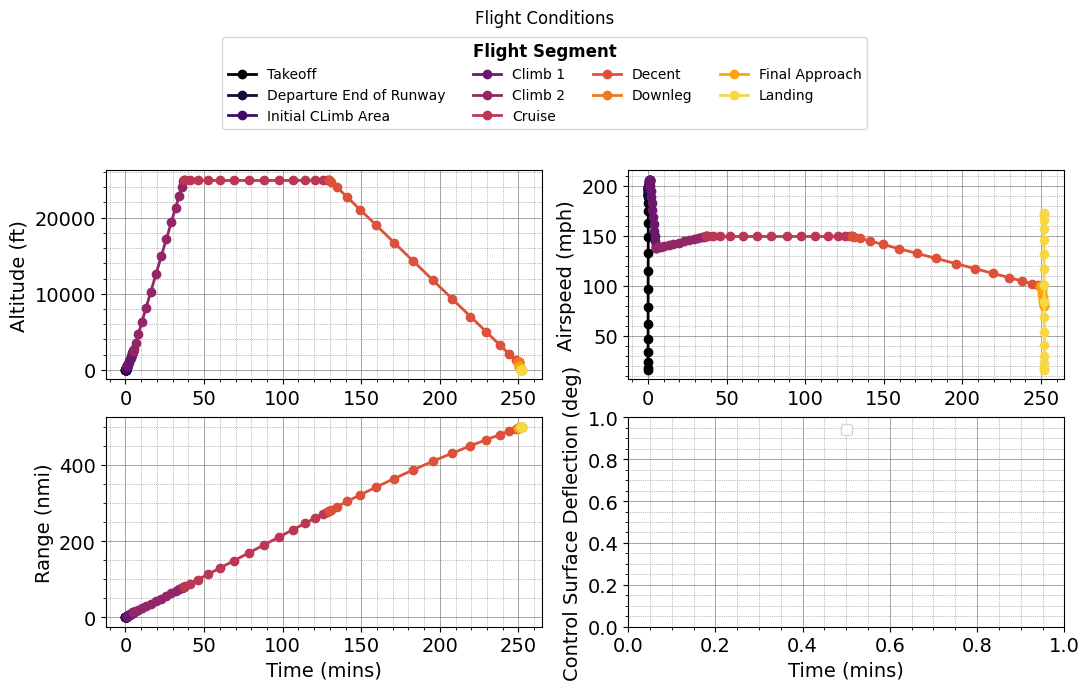

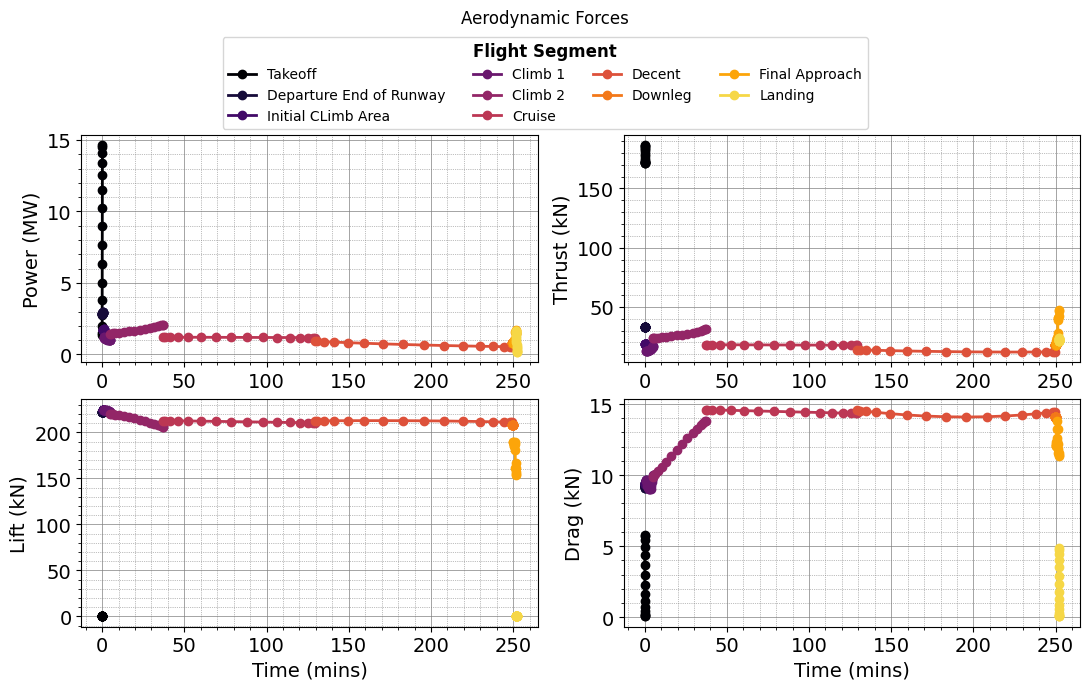

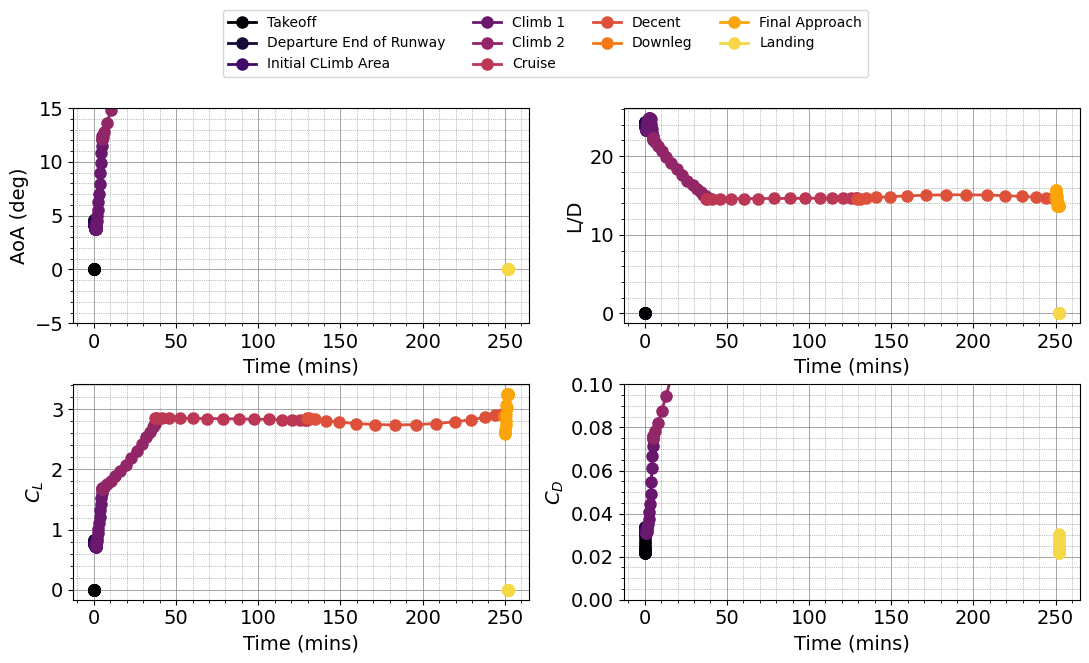

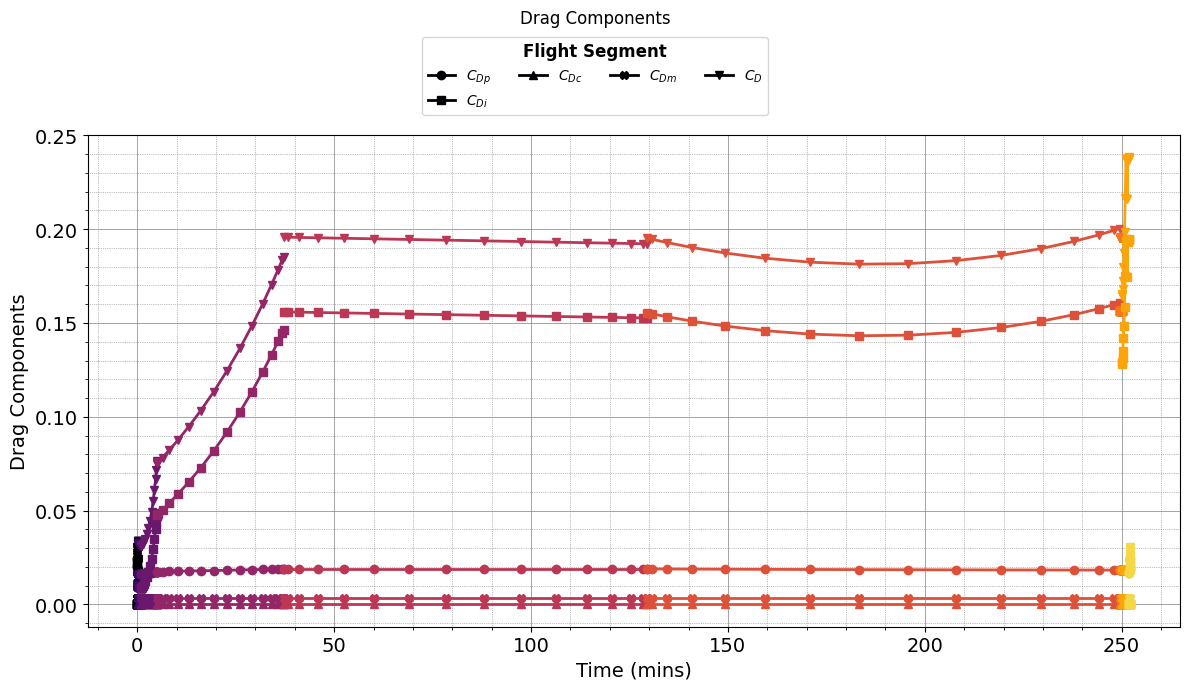

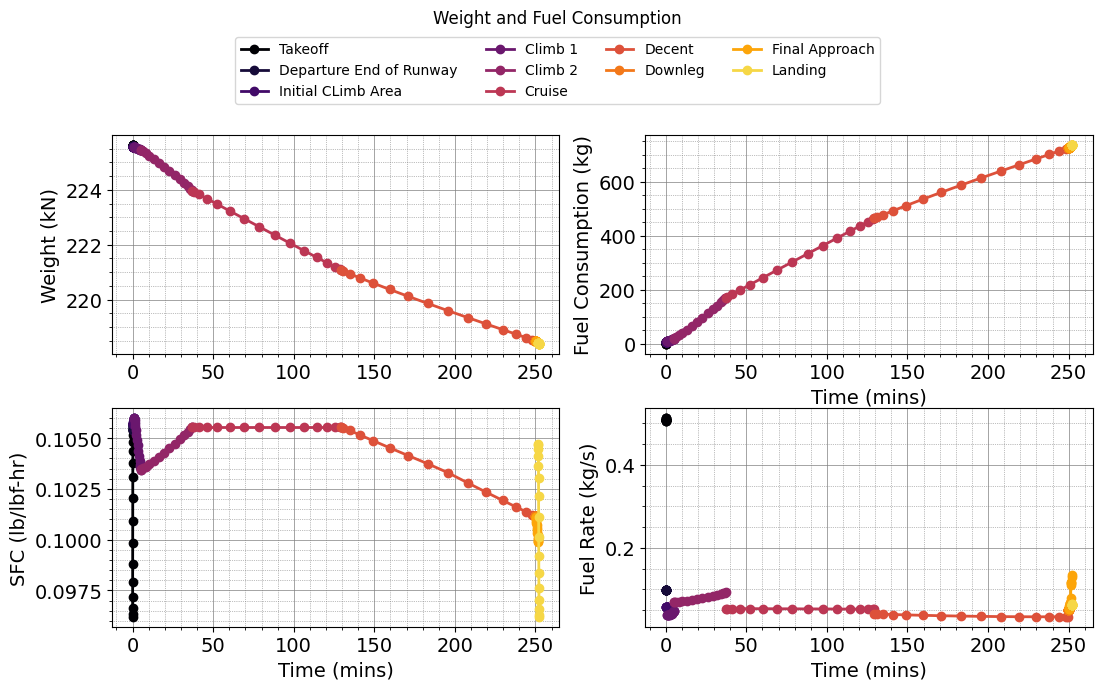

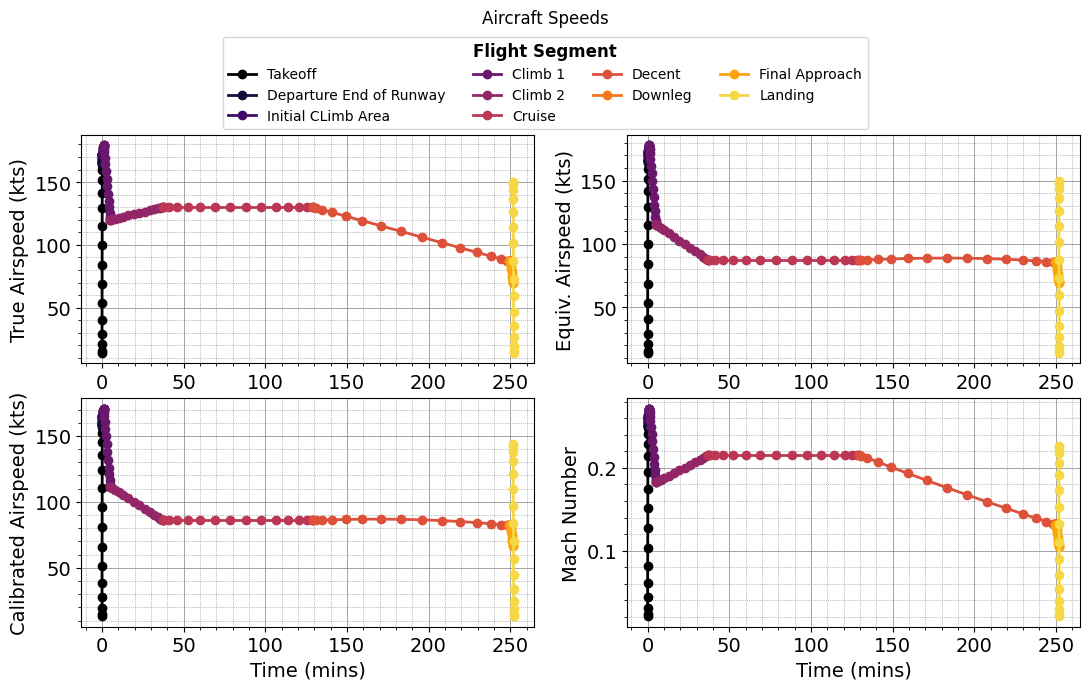

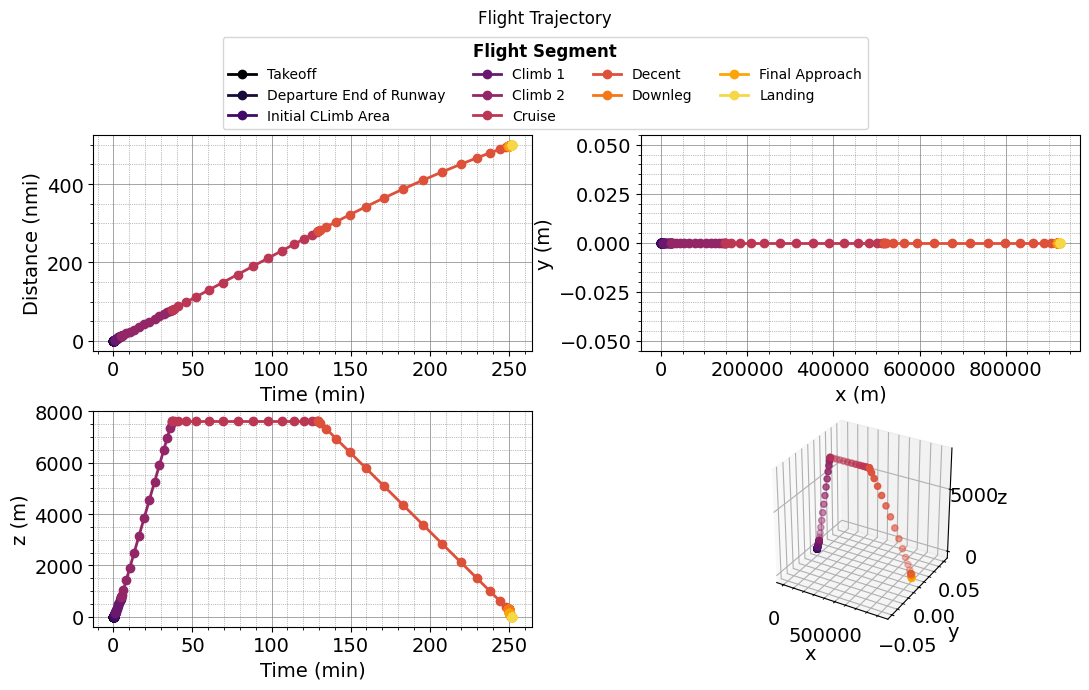

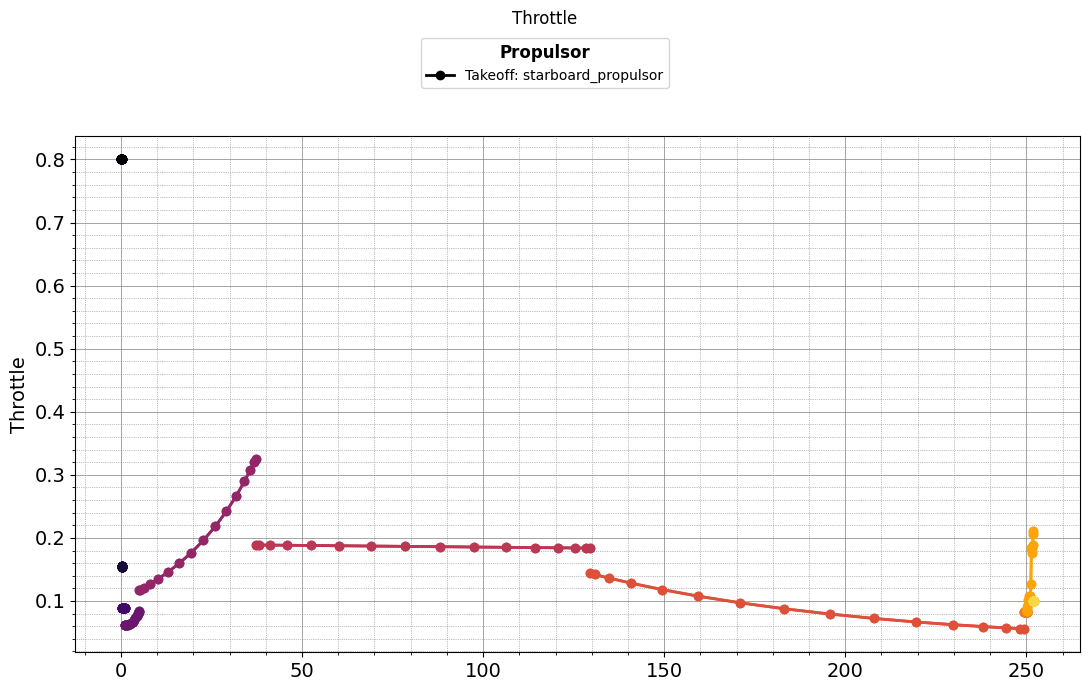

In [22]:

vehicle    = vehicle_setup()  

configs    = configs_setup(vehicle)
    
# create analyses
analyses = analyses_setup(configs)

# mission analyses
mission  = mission_setup(analyses) 

# create mission instances (for multiple types of missions)
missions = missions_setup(mission) 

# mission analysis 
results = missions.base_mission.evaluate()   

# plot the results 
plot_mission(results)  